In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.optimize import minimize
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import time
from joblib import Parallel, delayed
from sklearn.linear_model import lasso_path
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import fsolve
import pandas as pd
from tqdm.notebook import trange
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

disable_tqdm = False

In [2]:
# some initial states, periodic in [0,1]
def f_1(x):
    x = np.mod(x,1)
    a = -(16*(1+4*np.exp(1)+np.exp(2)))/(np.sqrt(np.exp(1))*(1-8*np.exp(1) + np.exp(2)))
    b = (16*(1+8*np.exp(1)+3*np.exp(2)))/(np.sqrt(np.exp(1))*(1-8*np.exp(1) + np.exp(2)))
    c = -(48*np.sqrt(np.exp(1))*(1+np.exp(1)))/(1-8*np.exp(1)+np.exp(2))
    d = (16*(-1+np.exp(1))*np.sqrt(np.exp(1)))/((1-8*np.exp(1) + np.exp(2)))
    return np.exp(x)*(a*(x**4) + b*(x**3) + c*(x**2) + d*x)
    
def f_2(x):
    x = np.mod(x,1)
    return 16*x**4-32*x**3+16*x**2


def clausen3(x, n = 500):
    # Clausen 3
    k = np.linspace(1,n, num=n, dtype=np.int64)
    result = np.zeros(x.shape)
    for i in k:
        result += np.cos(i*x*(2*np.pi))/i**3
    return result

max_clausen3 = clausen3(np.array([0.0]), n=10000)[0]
f_3 = lambda x: clausen3(x)-max_clausen3

In [3]:
def d_u_1(x):
    x = np.mod(x,1)
    a = -(16*(1+4*np.exp(1)+np.exp(2)))/(np.sqrt(np.exp(1))*(1-8*np.exp(1) + np.exp(2)))
    b = (16*(1+8*np.exp(1)+3*np.exp(2)))/(np.sqrt(np.exp(1))*(1-8*np.exp(1) + np.exp(2)))
    c = -(48*np.sqrt(np.exp(1))*(1+np.exp(1)))/(1-8*np.exp(1)+np.exp(2))
    d = (16*(-1+np.exp(1))*np.sqrt(np.exp(1)))/((1-8*np.exp(1) + np.exp(2)))
    return np.exp(x)*(d + 2*c*x + 3*b*x**2 + 4*a*x**3) + np.exp(x)*( d*x + c*x**2 + b*x**3 + a*x**4)

def d_u_2(x):
    x = np.mod(x,1)
    return 4*16*x**3-32*3*x**2+16*2*x

def d_u_3(x, n = 500):
    # Clausen 2
    k = np.linspace(1,n, num=n, dtype=np.int64)
    result = np.zeros(x.shape)
    for i in k:
        result += -i*(2*np.pi)*np.sin(i*x*(2*np.pi))/i**3
    return result

Considering custom PDE (some variant of the inviscid Burgers equation)

$\frac{\partial u}{\partial t} = u \frac{\partial u}{\partial x} \overset{\hat{ }}{=} \frac{1}{2} \frac{\partial u^2}{\partial x}$

with expected discretization

$u_i^{(n+1)} = u_i^{(n)} + \Delta t \left[u_i \frac{u_{i+1} - u_{i-1}}{2 \Delta x}\right]$

or

$u_i^{(n+1)} = u_i^{(n)} + \Delta t \frac{u_{i+1}^2 - u_{i-1}^2}{\Delta x}$

In [5]:
def root_fun(u_estimate, x, t, u0):
    """
    For solving the implicit equation in the analytic solution to the PDE
    """
    return u_estimate - u0(x+u_estimate*t)

def generate_data_analytic_ibe(xmin : float, xmax : float, tmin : float, tmax : float, delta_x : float, delta_t : float, f : callable):
    """
    Generates data for the custom PDE using the analytical solution.
    xmin, xmax : lower, upper limit spatial domain
    tmin, tmax : lower, upper limit temporal domain
    delta_x, delta_t : grid cell size
    u : initial state
    
    Returns: the approx. to the analytic solution
    ========
    
    """
    # generate x- and t values
    xs = np.arange(xmin, xmax, step=delta_x)
    ts = np.arange(tmin, tmax+delta_t, step=delta_t)
    u_sol = np.zeros((len(ts), len(xs)))
    dutest = np.zeros((len(ts)-1, len(xs)))
    
    u_sol[0] = f(xs)
    
    
    for x_id, x in enumerate(tqdm(xs)):
        for t_id, t in enumerate(ts):
            if t==0: # for t=0, u_sol is already populated with the initial state
                continue
            u_sol[t_id, x_id] = fsolve(root_fun, [1], (x,t,f))
    for x_id in range(len(xs)):
        for t_id in range(len(ts)-1):
            dutest[t_id, x_id] = (u_sol[t_id+1, x_id]-u_sol[t_id, x_id])/delta_t
    return xs, ts[:-1], u_sol[:-1,], dutest

In [6]:
def generate_data_custom_pde(xmin, xmax, delta_x, tmin, tmax, delta_t, u):
    """
    Generates data for the custom PDE above, using manual discretization
    xmin: minimal x value
    xmax: maximal xvalue (not contained)
    t_min : minimal t_value
    tmax : maximal t value (not contained)
    delta_x  / delta_t : grid cell size
    """
    # generate x- and t values
    x = np.arange(xmin, xmax, step=delta_x)
    t = np.arange(tmin, tmax, step=delta_t)
    
    # array to store the solution
    u_sol = np.zeros((len(t), len(x)))
    u_sol[0] = u(x) # initial state at t_min
    
    du = np.zeros((len(t), len(x))) #     corresponding array for du/dt
    for t_ind in range(1, len(t)): # iterate over time that is to be filled with values
        for x_ind in range(len(x)-1): # iterate over the central x
            step = u_sol[t_ind-1, x_ind]*(u_sol[t_ind-1, x_ind+1]-u_sol[t_ind-1, x_ind-1])/(2*delta_x) # approximate with central diff. scheme
            du[t_ind-1, x_ind] = step # according to PDE, this is equiv. to du/dt
            u_sol[t_ind, x_ind] = u_sol[t_ind-1, x_ind] + delta_t*step # explicit eulerian time stepping
        step = u_sol[t_ind-1, -1]*(u_sol[t_ind-1, 0]-u_sol[t_ind-1, -2])/(2*delta_x) # right-hand side boundary, same scheme as before
        u_sol[t_ind, -1] = u_sol[t_ind-1, -1] + delta_t*step # explicit eulerian time stepping
        du[t_ind-1, -1] = step # and set du/dt at this point
    # last time step, because we have only filled du up to index -2 so far
    for x_ind in range(len(x)-1): 
        step = u_sol[-1, x_ind]*(u_sol[-1, x_ind+1]-u_sol[-1, x_ind-1])/(2*delta_x) # central diff.
        du[-1, x_ind] = step # store
    step = u_sol[-1, -1]*(u_sol[-1, 0]-u_sol[-1, -2])/(2*delta_x) # right hand side boundary
    du[-1, -1] = step # store
    return x, t, u_sol, du

In [7]:
def generate_noisy_u_du(u_xt, du, noise):
    """
    Makes data noisy
    u_xt : data matrix t_points x r points
    du : corresponding derivative t_points x r_points
    noise : standard deviation relative to dynamic range of u_xt / du, that is added to the data
    """
    rng = np.random.default_rng()
    u_noisy = u_xt.copy() + noise*(np.max(u_xt)-np.min(u_xt))*rng.normal(size=u_xt.shape, loc=0, scale=1)
    du_noisy = du.copy() + noise*(np.max(du)-np.min(du))*rng.normal(size=du.shape, loc=0, scale=1)
    return u_noisy, du_noisy

In [8]:
def denoise_data(u_xt, y_t, sigma=10):
    """
    Denoises data by means of a spatial gaussian filter with periodic boundaries
    u_xt : data matrix t_points x r_points
    y_t : data matrix with derivative of u
    """
    # copies for the filtered data
    u_xt_filtered = u_xt.copy()
    y_t_filtered = y_t.copy()
    for t_ind in range(u_xt.shape[0]): # iterate over the t values
        u_xt_filtered[t_ind,:] = gaussian_filter1d(u_xt[t_ind,:], sigma, mode="wrap") # apply spatial gaussian filter
    # same for du/dt
    for t_ind in range(y_t.shape[0]):
        y_t_filtered[t_ind,:] = gaussian_filter1d(y_t[t_ind,:], sigma, mode="wrap")
    return u_xt_filtered, y_t_filtered

In [9]:
# some standard values
x_min = 0.0
x_max = 1.0
t_min = 0.0
t_max = 0.1
delta_x = 0.01
delta_t = 5e-4

In [10]:
def generate_target_matrix(uxt, du, indices, max_order):
    """
    Generates the matrices for the regression roblem
    uxt : data matrix t_points x r_points
    du : data matrix t_points x r_points
    indices : list of contributing nodes, e.g. [-1,0,1] for the central difference scheme
    max_order : max power of the polynomial expansion that is allowed
    """
    total_combinations_nodes = [] # list for tuples representing candidate variables, e.g. (-1,0) representing u_{i-1}u_{i+0}
    for order in range(1,max_order+1): # iterate over all polynomial expansions
        total_combinations_nodes.extend(list(itertools.combinations_with_replacement(indices, order))) # append all corresponding tuples
    # generate matrix for the left-hand-side of regression problem
    candidate_matrix = np.zeros((uxt.shape[0]*uxt.shape[1], len(total_combinations_nodes)))
    # corresponding RHS
    target_matrix = np.zeros((uxt.shape[0]*uxt.shape[1],))
    # iterate over the variables and their construction-tuples
    for variable_index, variable_constr in enumerate(total_combinations_nodes):
        for t_ind in range(uxt.shape[0]): # timestamp
            for x_ind in range(uxt.shape[1]): # central node
                data = np.array([uxt[t_ind, np.mod(x_ind + i,uxt.shape[1])] for i in variable_constr]) # select the data from the corresponding nodes
                candidate_matrix[t_ind*uxt.shape[1] + x_ind, variable_index] = np.prod(data) # multiply according to polynomial exp.
                target_matrix[t_ind*uxt.shape[1] + x_ind] = du[t_ind, x_ind] # fill in the corresponding derivative
    return candidate_matrix, target_matrix, total_combinations_nodes

In [11]:
def generate_regression_problem(uxt, du, indices, max_order, validation_size, test_size):
    """
    Generates train, test and validation sets for the regression problem
    uxt : data matrix t_points x r_points
    du : corresponding derivative matrix
    indices : see function above
    max_order : likewise
    validation_size : size of validation set
    test_size : size of test set
    """
    # sample train, test and validation set
    uxt_train= uxt[:uxt.shape[0]-validation_size-test_size]
    uxt_test = uxt[uxt.shape[0]-validation_size-test_size:uxt.shape[0]-validation_size]
    uxt_val = uxt[uxt.shape[0]-validation_size:]
    
    # sample corresponding derivatives for train and validation set
    du_train= du[:du.shape[0]-validation_size-test_size]
    du_val = du[du.shape[0]-validation_size:]
    
    # generate corresponding training and validation matrices
    candidate_matrix_train, target_matrix_train, total_combinations_nodes = generate_target_matrix(uxt_train, du_train, indices, max_order)
    candidate_matrix_val, target_matrix_val, total_combinations_nodes = generate_target_matrix(uxt_val, du_val, indices, max_order)
    
    return candidate_matrix_train, target_matrix_train, candidate_matrix_val, target_matrix_val, total_combinations_nodes, uxt_val, uxt_test

In [12]:
def loss(u_xt, coeffs, support, n_steps, delta_t, plot=False, return_prop=False):
    """
    Computes the propagation error for n_steps new time steps (N+1) timepoints
    u_xt : datamatrix
    coeffs : array with regressed coefficients
    support : the construction tuples for the considered variables in stencil regression
    n_steps : number of timesteps to compute. Attention: this differs from MostStableStencil.ipynb, but we always compute it as n_steps = dataset.shape[0]-1!
    delta_t : step size
    """
    # copy for the propagated solution
    u_propagated = u_xt.copy()
    # iterate over the t_indices
    for t_index in range(0, n_steps):
        for x_index in range(u_xt.shape[1]): # the central nodes
            step = 0.0 # place holder
            for constr_index, variable_constr in enumerate(support): # iterate over construction tuples
                # assemble data per tuple
                data = np.array([u_propagated[t_index, np.mod(x_index + i,u_propagated.shape[1])] for i in variable_constr])
                step += coeffs[constr_index]*np.prod(data) # and compute the corresponding contribution to the step size
            u_propagated[t_index+1, x_index] = u_propagated[t_index, x_index] + delta_t*step # Attention: here, we approximated du/dt by the RHS of the PDE --> we still need to multiply it with delta_t
    if return_prop:
        return u_propagated
    return np.sum(np.abs(u_propagated-u_xt)) # kumulierte Abweichung

In [13]:
def parallel_evaluation(stencil_length, indices, candidate_matrix_train, target_matrix_train, total_combinations_nodes, uxt_val, uxt_test, delta_t):
    """
    Parallel Function for exhaustive search.
    stencil_length : length of the stencil tht is considered here
    indices : the indices of the available variables
    candidate_matrix_train, target_matrix_train : as before
    total_combinations_nodes : the numpy-array of construction-tuples
    uxt_val : data matrix with validation set
    uxt_test : data matrix with test set
    delta_t : grid cell size in time
    """
    
    # initial state
    minimal_loss = 1e20
    minimal_coeffs = None
    minimal_node = None
    minimal_index_support = None
    
    for node_support in itertools.combinations(indices, stencil_length): # iterate over unique combinations without replacement
        # perform linear regression
        lr = LinearRegression(fit_intercept=False)
        X = candidate_matrix_train[:,node_support]
        lr.fit(X, target_matrix_train)
        # evaluate propagation error
        loss_val = loss(uxt_val, lr.coef_, total_combinations_nodes[np.array(list(node_support))], uxt_val.shape[0]-1, delta_t)
        # if propagation error is better than current minimum --> replace the current optimum
        if loss_val<minimal_loss and not np.any(np.abs(lr.coef_)<0.05*np.max(np.abs(lr.coef_))):
            minimal_loss = loss_val
            minimal_coeffs = lr.coef_
            minimal_node = total_combinations_nodes[np.array(list(node_support))]
            minimal_index_support = node_support
    # return optimum for this stencil size
    return minimal_loss, minimal_coeffs, minimal_node, minimal_index_support
    

def exhaustive_search(candidate_matrix_train, target_matrix_train, candidate_matrix_val, target_matrix_val, total_combinations_nodes, uxt_val, uxt_test, delta_t):
    """
    Exhaustive search over all combinations of candidate tuples
    candidate_matrix_train : the training matrix (x, num_possible_variables)
    target_matrix_train : corresponding RHS for the regression
    candidate_matrix_val : LHS of a regression problem on the validation set
    target_matrix_val : corresponding right-hand side
    total_combinations_nodes : list with construction tuples
    uxt_val : data matrix with the validation set
    uxt_test : data matrix with the test set
    delta_t : grid cell size in time
    """
    # make numpy array
    total_combinations_nodes = np.array(total_combinations_nodes, dtype="object")
    
    # initial state
    minimal_loss = 1e20 # prop. error on sel. variables
    minimal_coeffs = None # coefficients minimizing the prop. error
    minimal_node = None # the construction tuples for the optimal set of variables
    minimal_index_support = None # the indices of the best set of variables in candidate_matrix_*
    
    # the indices of the available variables
    indices = np.arange(candidate_matrix_train.shape[1])
    
    # start time measurement
    time1 = time.time()
    # on 4 joblib processes, parallelize the exhaustive search over the individual index sizes0
    results = Parallel(n_jobs=4)(delayed(parallel_evaluation)(stencil_length, indices, candidate_matrix_train, target_matrix_train, total_combinations_nodes, uxt_val, uxt_test, delta_t) for stencil_length in range(2, len(indices)+1))
    
    # the losses from the parallel runs
    min_losses = [results[i][0] for i in range(len(results))]
    # select minimal loss
    best_index = np.nanargmin(min_losses)
    # corresponding result
    minimal_loss, minimal_coeffs, minimal_node, minimal_index_support = results[best_index]
    time2 = time.time() # stop timing
    time_diff = time2 - time1
    
    X = np.concatenate((candidate_matrix_train[:,minimal_index_support],candidate_matrix_val[:,minimal_index_support]), axis=0)
    y = np.hstack((target_matrix_train, target_matrix_val))
    #lr = LinearRegression(fit_intercept=False)
    #lr.fit(X,y)
    
    return minimal_node, minimal_loss, minimal_coeffs, time_diff, X, y

In [14]:
def parallel_evaluation_be(left_out_node, current_support, candidate_matrix_train, target_matrix_train, uxt_val, total_combinations_nodes, delta_t):
    """
    Parallel function for backward elimination
    left_out_node : the variable to leave out
    """
    # corresponding LHS of regression
    X = candidate_matrix_train[:,current_support[current_support!=left_out_node]]
    # perform OLS fit
    lr = LinearRegression(fit_intercept=False)
    lr.fit(X,target_matrix_train)
    # compute respective propagation error
    loss_val = loss(uxt_val, lr.coef_, total_combinations_nodes[current_support[current_support!=left_out_node]], uxt_val.shape[0]-1, delta_t)
    return left_out_node, loss_val, lr.coef_


def stencil_selection_be(num_features, candidate_matrix_train, target_matrix_train, candidate_matrix_val, target_matrix_val, total_combinations_nodes, uxt_val, uxt_test, delta_t):
    """
    Select variables by backward elimination.
    num_features : requested nuber of features
    all other arguments as above
    """
    # make numpy array
    total_combinations_nodes = np.array(total_combinations_nodes, dtype="object")
    # currently considered indices of variables
    current_support = np.arange(candidate_matrix_train.shape[1])
    # validation-losses after each elimination
    final_losses = []
    # corresponding coefficients after each elimination
    final_coeffs = []
    # start timing
    time1 = time.time()
    iteration_idx = 1
    # reduce the support of regression, until the corresponding number of features is reached
    while len(current_support)>num_features:
        # find optimal elimination in parallel
        results = Parallel(n_jobs=4)(delayed(parallel_evaluation_be)(left_out_node, current_support, candidate_matrix_train, target_matrix_train, uxt_val, total_combinations_nodes, delta_t) for left_out_node in current_support)
        # all the respective losses
        losses = [results[i][1] for i in range(len(results))]
        minimal_loss_index = np.nanargmin(losses) # get index of minimum
        
        least_relevant_node = results[minimal_loss_index][0] # get least relevant node
        current_support = np.delete(current_support, np.nonzero(current_support==least_relevant_node)) # reduce support
        # store current state
        final_losses.append(losses[minimal_loss_index])
        final_coeffs.append(results[minimal_loss_index][2])
        
        iteration_idx+=1
        
    time2 = time.time() # stop timing
    
    time_diff = time2-time1
    
    last_loss = final_losses[-1]
    last_node = total_combinations_nodes[current_support]
    last_coeffs = final_coeffs[-1]
    
    
    X = np.concatenate((candidate_matrix_train[:,current_support],candidate_matrix_val[:,current_support]), axis=0)
    y = np.hstack((target_matrix_train, target_matrix_val))
    #lr = LinearRegression(fit_intercept=False)
    #lr.fit(X,y)
    
    return last_node, current_support, last_loss, final_coeffs[-1], time_diff, final_losses, X, y

In [15]:
def be_and_exhaustive_search(num_features_be, candidate_matrix_train, target_matrix_train, candidate_matrix_val, target_matrix_val, total_combinations_nodes, uxt_val, uxt_test, delta_t):
    """
    The combined method with backward elimination, followed by exhaustive search
    num_features_be : reduce by backward elimmination to this number of variables
    
    """
    # start timing
    time1 = time.time()
    # backward elimination
    last_node, current_support, last_loss, last_coeffs, time_diff, final_losses, X, y = stencil_selection_be(num_features_be, candidate_matrix_train, target_matrix_train, candidate_matrix_val, target_matrix_val, total_combinations_nodes, uxt_val, uxt_test, delta_t)
    # exhaustive search
    minimal_node, minimal_loss, coef, time_diff, X, y = exhaustive_search(candidate_matrix_train[:, current_support], target_matrix_train, candidate_matrix_val[:, current_support], target_matrix_val, last_node, uxt_val, uxt_test, delta_t)
    # stop timing
    time2 = time.time()
    
    time_diff = time2-time1
    return minimal_node, minimal_loss, coef, time_diff, X, y

In [16]:
def parallel_evaluation_stability_selection(M, weakness, candidate_matrix_train, target_matrix_train):
    """
    Parallel function for stability selection
    M : number of regularization values to use
    weakness : weakness of the randomized lasso
    everything else as usual ;)
    """
    rng = np.random.default_rng()
    # randomly select subset of matrix
    indices = rng.choice(np.arange(candidate_matrix_train.shape[0]), size=candidate_matrix_train.shape[0]//2, replace=False)
    X, y = candidate_matrix_train[indices,:], target_matrix_train[indices]
    # standardize data
    X = StandardScaler().fit_transform(X)
    # scale each feature by weakness
    X = X*rng.uniform(weakness, 1, size=X.shape[1])
    # compute the corresponding coefficients along the regularization path
    lambdas, coeffs, _ = lasso_path(X, y, eps=0.1, n_alphas=M, max_iter=10000000)
    return lambdas, coeffs.transpose() # coefficients in shape (n_lambdas x n_variables)
    
def stability_selection(num_B, M, weakness, candidate_matrix_train, target_matrix_train, total_combinations_nodes, threshold=0.7):
    """
    Perform stability selection
    num_B : number of iterations
    M : number of regularization values
    weakness : weakness of Rand.Lass.
    ...
    threshold : minimal selection probability to be considered as selected variable
    """
    # make numpy array
    total_combinations_nodes = np.array(total_combinations_nodes, dtype="object")
    # start timing
    time1 = time.time()
    # evaluate in parallel
    results = Parallel(n_jobs=4)(delayed(parallel_evaluation_stability_selection)(M, weakness, candidate_matrix_train, target_matrix_train) for _ in range(num_B))
    # selected support
    selected_support = [np.abs((results[i][1]))>=1e-5 for i in range(len(results))]
    # compute selection probability
    selection_probability = np.mean(np.array(selected_support), axis=0) # probability along the repetition axis
    node_indices = np.nonzero(selection_probability[M-1,:]>threshold)[0] # where selection probability is > threshold for the lowest regularization
    nodes = total_combinations_nodes[node_indices] # corresponding variables
    time2 = time.time() # stop timing
    time_diff = time2-time1
    
    lambdas = np.array([results[i][0] for i in range(len(results))])
    lambdas = np.mean(lambdas, axis=0) # compute mean lambda values for regularization.
    
    # perform reg. regression on the selected set of variables
    lr = LinearRegression(fit_intercept=False)
    lr.fit(candidate_matrix_train[:,node_indices], target_matrix_train)
    coeffs = lr.coef_
    
    return lambdas, selection_probability, nodes, node_indices, coeffs, time_diff


In [17]:
def evaluate_method(repetitions, noise, f, n, m=1):
    """
    Evaluate the all considered methods in multiple repetitions
    repetitions : number of repetitions
    noise : noise level to add
    f : function
    n : subsampling in time
    m : subsampling in space
    """
    
    method_list = [] # list for the considered methods
    test_loss_list = [] # list for the corresponding test losses
    time_sol_list = [] # list for the time to solution
    
    # corresponding variables that were selected
    nodes_stab = []
    nodes_be = []
    nodes_comb = []
    nodes_exh = []
    
    # repeat computations
    for rep in trange(repetitions):
        # generate data
        print(x_min, x_max, t_min, t_max, delta_x, delta_t, f)
        x, t, u_sol, du = generate_data_analytic_ibe(x_min, x_max, t_min, t_max, delta_x, delta_t, f)
        print("Generated data")
        #x, t, u_sol, du = generate_data_custom_pde(x_min, x_max, delta_x, t_min, t_max, delta_t, f)
        # sub-sample space, time and the data matrices according to m and n
        x = x[::m]
        t = t[::n]
        u_sol = u_sol[::n]
        u_sol = u_sol[:,::m]
        du = du[::n]
        du = du[:,::m]
        # if we're to add noise
        if noise!=0.0:
            u_sol_noisy, du_noisy = generate_noisy_u_du(u_sol, du, noise)  # add noise
            u_sol_filtered, du_filtered = denoise_data(u_sol_noisy, du_noisy, sigma=2) # and de-noise again
        else:
            u_sol_filtered, du_filtered = u_sol, du # otherwise: don't filter
        
        # generate matrices for nodes [-1,0,1] and max order of 2,20% validation set, 10% test set
        candidate_matrix_train, target_matrix_train, candidate_matrix_val, target_matrix_val, total_combinations_nodes, uxt_val, uxt_test = generate_regression_problem(u_sol_filtered, du_filtered, [-1,0,1], 2, int(u_sol.shape[0]*0.2), int(u_sol.shape[0]*0.1))
        
        # stability selection may use train + val
        X_stab, y_stab = np.concatenate((candidate_matrix_train, candidate_matrix_val), axis=0), np.concatenate((target_matrix_train, target_matrix_val), axis=0)
        # B = 250, num_lambdas = 20, weakness = 0.2, tau = 0.7
        lambdas, selection_probability, nodes, node_indices, coeffs, time_diff = stability_selection(250, 20, 0.2, X_stab, y_stab, total_combinations_nodes, 0.7)
        # corresponding test set
        loss_test = loss(uxt_test, coeffs, nodes, uxt_test.shape[0]-1, delta_t*n)
        # store results
        method_list.append("Stability Selection")
        time_sol_list.append(time_diff)
        test_loss_list.append(loss_test)
        nodes_stab.append(list(nodes))
        print("Method: {}, Time to solution: {}, Test Loss {}, Nodes {}".format(method_list[-1], time_sol_list[-1], test_loss_list[-1], nodes))
        
        # backward-elimination
        last_node, current_support, last_loss, last_coeffs, time_diff, final_losses, Xbe, ybe = stencil_selection_be(2, candidate_matrix_train, target_matrix_train, candidate_matrix_val, target_matrix_val, total_combinations_nodes, uxt_val, uxt_test, delta_t*n)
        loss_test = loss(uxt_test, last_coeffs, last_node, uxt_test.shape[0]-1, delta_t*n)
        
        method_list.append("Backward Elimination")
        time_sol_list.append(time_diff)
        test_loss_list.append(loss_test)
        nodes_be.append(list(last_node))
        print("Method: {}, Time to solution: {}, Val. Loss {}, Test Loss {}, Nodes {}".format(method_list[-1], time_sol_list[-1], last_loss, test_loss_list[-1], last_node))
        
        # backward-elimination + exhaustive search
        # F = 7
        minimal_node, minimal_loss, coef, time_diff, Xbees, ybees = be_and_exhaustive_search(7, candidate_matrix_train, target_matrix_train, candidate_matrix_val, target_matrix_val, total_combinations_nodes, uxt_val, uxt_test, delta_t*n)
        loss_test = loss(uxt_test, coef, minimal_node, uxt_test.shape[0]-1, delta_t*n)
        
        method_list.append("BE + Exhaustive Search")
        time_sol_list.append(time_diff)
        test_loss_list.append(loss_test)
        nodes_comb.append(list(minimal_node))
        print("Method: {}, Time to solution: {}, Val. Loss{}, Test Loss {}, Nodes {}".format(method_list[-1], time_sol_list[-1], minimal_loss, test_loss_list[-1], minimal_node))
        
        # exhaustive search
        minimal_node, minimal_loss, coef_, time_diff, Xes, yes = exhaustive_search(candidate_matrix_train, target_matrix_train, candidate_matrix_val, target_matrix_val, total_combinations_nodes, uxt_val, uxt_test, delta_t*n)
        loss_test = loss(uxt_test, coef_, minimal_node, uxt_test.shape[0]-1, delta_t*n)
        
        method_list.append("Exhaustive Search")
        time_sol_list.append(time_diff)
        test_loss_list.append(loss_test)
        nodes_exh.append(list(minimal_node))
        print("Method: {}, Time to solution: {}, Val. Loss {}, Test Loss {}, Nodes {}".format(method_list[-1], time_sol_list[-1], minimal_loss, test_loss_list[-1], minimal_node))
    

    results = pd.DataFrame({"Method":method_list, "Loss":test_loss_list, "Time":time_sol_list})
    results = pd.pivot_table(data=results, values=["Time", "Loss"], index="Method", aggfunc=lambda x: str(np.nanmean(x)) + "+-" + str(np.nanstd(x)))
    print(results)
    
    print("Stability selection {}".format(nodes_stab))
    print("Backward Elimination {}".format(nodes_be))
    print("Combined Method {}".format(nodes_comb))
    print("Exhaustive Search {}".format(nodes_exh))
    
    return results
    

# Evaluations for Table 2

### Evaluation with $f_3(x)$

In [19]:
results_0_noise = evaluate_method(10, 0.0, f_3, n=1)

  0%|          | 0/10 [00:00<?, ?it/s]

0.0 1.0 0.0 0.1 0.01 0.0005 <function <lambda> at 0x000001906890F0D0>
Generated data
Method: Stability Selection, Time to solution: 2.9348032474517822, Test Loss 0.20192414433566802, Nodes [(-1, -1) (1, 1)]
Method: Backward Elimination, Time to solution: 4.2198240756988525, Val. Loss 4.4473028670138985, Test Loss 0.8023364600197135, Nodes [(0, 0) (0, 1)]
Method: BE + Exhaustive Search, Time to solution: 10.1954345703125, Val. Loss0.41830071158198645, Test Loss 0.07019678913841208, Nodes [(-1, 1) (0, 0) (0, 1) (1, 1)]
Method: Exhaustive Search, Time to solution: 44.14150857925415, Val. Loss 0.3653072827323836, Test Loss 0.0656831612080803, Nodes [(-1, 0) (-1, 1) (0, 0) (0, 1) (1, 1)]
0.0 1.0 0.0 0.1 0.01 0.0005 <function <lambda> at 0x000001906890F0D0>
Generated data
Method: Stability Selection, Time to solution: 2.7193384170532227, Test Loss 0.20192414433566802, Nodes [(-1, -1) (1, 1)]
Method: Backward Elimination, Time to solution: 4.197901487350464, Val. Loss 4.4473028670138985, Test

In [20]:
results_1_noise = evaluate_method(10, 1e-4, f_3, n=1)

  0%|          | 0/10 [00:00<?, ?it/s]

0.0 1.0 0.0 0.1 0.01 0.0005 <function <lambda> at 0x000001906890F0D0>
Generated data
Method: Stability Selection, Time to solution: 2.6921494007110596, Test Loss 0.5461704737676926, Nodes [(-1, -1) (1, 1)]
Method: Backward Elimination, Time to solution: 4.117544651031494, Val. Loss 3.390404850934194, Test Loss 0.7021340430594638, Nodes [(-1, -1) (0, 1)]
Method: BE + Exhaustive Search, Time to solution: 10.033647298812866, Val. Loss0.5167080057309272, Test Loss 0.20104717233361818, Nodes [(-1, -1) (-1, 0) (-1, 1) (0, 0) (0, 1)]
Method: Exhaustive Search, Time to solution: 40.49745297431946, Val. Loss 0.4932634301045814, Test Loss 0.20006997728700293, Nodes [(-1, -1) (-1, 0) (-1, 1) (0, 0) (1, 1)]
0.0 1.0 0.0 0.1 0.01 0.0005 <function <lambda> at 0x000001906890F0D0>
Generated data
Method: Stability Selection, Time to solution: 2.7545735836029053, Test Loss 0.5385598247636502, Nodes [(-1, -1) (1, 1)]
Method: Backward Elimination, Time to solution: 4.183510780334473, Val. Loss 3.4953324835

In [21]:
results_2_noise = evaluate_method(10, 5e-4, f_3, n=1)

  0%|          | 0/10 [00:00<?, ?it/s]

0.0 1.0 0.0 0.1 0.01 0.0005 <function <lambda> at 0x000001906890F0D0>
Generated data
Method: Stability Selection, Time to solution: 2.725332498550415, Test Loss 1.2752184213125979, Nodes [(-1, -1) (1, 1)]
Method: Backward Elimination, Time to solution: 4.076044797897339, Val. Loss 3.3169875391618926, Test Loss 1.2836762733452562, Nodes [(-1, -1) (1, 1)]
Method: BE + Exhaustive Search, Time to solution: 9.987049102783203, Val. Loss1.642135787356739, Test Loss 0.9818000168758122, Nodes [(-1, -1) (-1, 0) (0, 1) (1, 1)]
Method: Exhaustive Search, Time to solution: 40.863651514053345, Val. Loss 1.6162046373839463, Test Loss 0.9904331153464805, Nodes [(-1, -1) (-1, 1) (0, 0) (0, 1) (1, 1)]
0.0 1.0 0.0 0.1 0.01 0.0005 <function <lambda> at 0x000001906890F0D0>
Generated data
Method: Stability Selection, Time to solution: 2.7423505783081055, Test Loss 0.9436235879871101, Nodes [(-1, -1) (1, 1)]
Method: Backward Elimination, Time to solution: 4.380881071090698, Val. Loss 3.7867269273102324, Test

### Evaluation with $f_2(x)$

In [22]:
results_3_noise = evaluate_method(10, 0.0, f_2, n=1)

  0%|          | 0/10 [00:00<?, ?it/s]

0.0 1.0 0.0 0.1 0.01 0.0005 <function f_2 at 0x00000190688DBF70>
Generated data
Method: Stability Selection, Time to solution: 1.1407561302185059, Test Loss 0.020776762881413932, Nodes [(-1, -1) (1, 1)]
Method: Backward Elimination, Time to solution: 4.989503383636475, Val. Loss 0.5658060780471431, Test Loss 0.1219732292653344, Nodes [(-1, 0) (0, 0)]
Method: BE + Exhaustive Search, Time to solution: 13.181279182434082, Val. Loss0.04453884067658996, Test Loss 0.010218360072621335, Nodes [(-1, -1) (-1, 0) (-1, 1) (0, 0)]
Method: Exhaustive Search, Time to solution: 49.96659278869629, Val. Loss 0.03569824548862434, Test Loss 0.007925344005476613, Nodes [(-1, -1) (-1, 0) (-1, 1) (0, 0) (0, 1) (1, 1)]
0.0 1.0 0.0 0.1 0.01 0.0005 <function f_2 at 0x00000190688DBF70>
Generated data
Method: Stability Selection, Time to solution: 1.0762450695037842, Test Loss 0.020776762881413932, Nodes [(-1, -1) (1, 1)]
Method: Backward Elimination, Time to solution: 5.178206920623779, Val. Loss 0.565806078047

In [23]:
results_4_noise = evaluate_method(10, 1e-4, f_2, n=1)

  0%|          | 0/10 [00:00<?, ?it/s]

0.0 1.0 0.0 0.1 0.01 0.0005 <function f_2 at 0x00000190688DBF70>
Generated data
Method: Stability Selection, Time to solution: 1.137758493423462, Test Loss 0.11325088345690267, Nodes [(-1, -1) (1, 1)]
Method: Backward Elimination, Time to solution: 4.596704721450806, Val. Loss 0.7168892016354992, Test Loss 0.15462642421390987, Nodes [(-1, 0) (1, 1)]
Method: BE + Exhaustive Search, Time to solution: 12.17435908317566, Val. Loss0.19941814437972438, Test Loss 0.07741657316707648, Nodes [(-1, 0) (-1, 1) (0, 0) (0, 1) (1, 1)]
Method: Exhaustive Search, Time to solution: 46.960785150527954, Val. Loss 0.19310608812664765, Test Loss 0.07709587402113427, Nodes [(-1, -1) (-1, 0) (0, 1) (1, 1)]
0.0 1.0 0.0 0.1 0.01 0.0005 <function f_2 at 0x00000190688DBF70>
Generated data
Method: Stability Selection, Time to solution: 1.0444741249084473, Test Loss 0.10850592423521845, Nodes [(-1, -1) (1, 1)]
Method: Backward Elimination, Time to solution: 4.352725505828857, Val. Loss 0.35890529975753066, Test Lo

In [24]:
results_5_noise = evaluate_method(10, 5e-4, f_2, n=1)

  0%|          | 0/10 [00:00<?, ?it/s]

0.0 1.0 0.0 0.1 0.01 0.0005 <function f_2 at 0x00000190688DBF70>
Generated data
Method: Stability Selection, Time to solution: 1.129343032836914, Test Loss 0.39022966420294114, Nodes [(-1, -1) (1, 1)]
Method: Backward Elimination, Time to solution: 4.608884334564209, Val. Loss 1.0134794627447299, Test Loss 0.4071136618411332, Nodes [(-1, 0) (1, 1)]
Method: BE + Exhaustive Search, Time to solution: 12.572269201278687, Val. Loss0.7084295460777552, Test Loss 0.38166028371032584, Nodes [(-1, 0) (-1, 1) (0, 0) (0, 1) (1, 1)]
Method: Exhaustive Search, Time to solution: 46.0230507850647, Val. Loss 0.7084295460777552, Test Loss 0.38166028371032584, Nodes [(-1, 0) (-1, 1) (0, 0) (0, 1) (1, 1)]
0.0 1.0 0.0 0.1 0.01 0.0005 <function f_2 at 0x00000190688DBF70>
Generated data
Method: Stability Selection, Time to solution: 1.1400701999664307, Test Loss 0.4067019594169403, Nodes [(-1, -1) (1, 1)]
Method: Backward Elimination, Time to solution: 4.305016994476318, Val. Loss 1.018584447568039, Test Los

### Evaluation with $f_1(x)$

In [25]:
results_6_noise = evaluate_method(10, 0.0, f_1, n=1)

  0%|          | 0/10 [00:00<?, ?it/s]

0.0 1.0 0.0 0.1 0.01 0.0005 <function f_1 at 0x0000019014F5AF70>
Generated data
Method: Stability Selection, Time to solution: 0.9237298965454102, Test Loss 0.04256020838007107, Nodes [(-1, -1) (1, 1)]
Method: Backward Elimination, Time to solution: 4.1267876625061035, Val. Loss 1.0921038802015444, Test Loss 0.22579833773736047, Nodes [(-1, 0) (0, 0)]
Method: BE + Exhaustive Search, Time to solution: 10.850715637207031, Val. Loss0.09195178031068464, Test Loss 0.020581843209273108, Nodes [(-1, -1) (-1, 0) (-1, 1) (0, 0) (1, 1)]
Method: Exhaustive Search, Time to solution: 47.55408024787903, Val. Loss 0.09108087796882268, Test Loss 0.020390424487920743, Nodes [(-1, -1) (-1, 1) (0, 0) (0, 1) (1, 1)]
0.0 1.0 0.0 0.1 0.01 0.0005 <function f_1 at 0x0000019014F5AF70>
Generated data
Method: Stability Selection, Time to solution: 0.9656054973602295, Test Loss 0.04256020838007107, Nodes [(-1, -1) (1, 1)]
Method: Backward Elimination, Time to solution: 5.034198760986328, Val. Loss 1.0921038802015

In [26]:
results_7_noise = evaluate_method(10, 1e-4, f_1, n=1)

  0%|          | 0/10 [00:00<?, ?it/s]

0.0 1.0 0.0 0.1 0.01 0.0005 <function f_1 at 0x0000019014F5AF70>
Generated data
Method: Stability Selection, Time to solution: 0.9993455410003662, Test Loss 0.16725866050497176, Nodes [(-1, -1) (1, 1)]
Method: Backward Elimination, Time to solution: 4.758842706680298, Val. Loss 0.9540626177459429, Test Loss 0.2144544373886761, Nodes [(0, 0) (0, 1)]
Method: BE + Exhaustive Search, Time to solution: 13.08316707611084, Val. Loss0.2471207816135419, Test Loss 0.10101480258115121, Nodes [(-1, -1) (-1, 0) (-1, 1) (0, 0) (0, 1)]
Method: Exhaustive Search, Time to solution: 47.31029772758484, Val. Loss 0.2471207816135419, Test Loss 0.10101480258115121, Nodes [(-1, -1) (-1, 0) (-1, 1) (0, 0) (0, 1)]
0.0 1.0 0.0 0.1 0.01 0.0005 <function f_1 at 0x0000019014F5AF70>
Generated data
Method: Stability Selection, Time to solution: 0.9522790908813477, Test Loss 0.1743463208790827, Nodes [(-1, -1) (1, 1)]
Method: Backward Elimination, Time to solution: 4.506917476654053, Val. Loss 1.2821358950298265, Tes

In [27]:
results_8_noise = evaluate_method(10, 5e-4, f_1, n=1)

  0%|          | 0/10 [00:00<?, ?it/s]

0.0 1.0 0.0 0.1 0.01 0.0005 <function f_1 at 0x0000019014F5AF70>
Generated data
Method: Stability Selection, Time to solution: 0.9637260437011719, Test Loss 0.5451201867493586, Nodes [(-1, -1) (1, 1)]
Method: Backward Elimination, Time to solution: 4.691348552703857, Val. Loss 1.372116527104864, Test Loss 0.5776397176147952, Nodes [(0, 0) (0, 1)]
Method: BE + Exhaustive Search, Time to solution: 12.300756692886353, Val. Loss1.020513791401285, Test Loss 0.5327380311801276, Nodes [(-1, -1) (-1, 0) (-1, 1) (0, 0) (0, 1)]
Method: Exhaustive Search, Time to solution: 49.73161768913269, Val. Loss 1.006856667029353, Test Loss 0.5337236260331895, Nodes [(-1, 0) (-1, 1) (0, 0) (0, 1) (1, 1)]
0.0 1.0 0.0 0.1 0.01 0.0005 <function f_1 at 0x0000019014F5AF70>
Generated data
Method: Stability Selection, Time to solution: 0.9869608879089355, Test Loss 0.5203499616915875, Nodes [(-1, -1) (1, 1)]
Method: Backward Elimination, Time to solution: 4.26054310798645, Val. Loss 1.946589450615563, Test Loss 0.

# Reviewer Comment on Plot with Actual Solution Trajectories

In [93]:
x, t, u_sol, du = generate_data_analytic_ibe(x_min, x_max, t_min, t_max, delta_x, delta_t, f_3)
u_sol_filtered, du_filtered = u_sol, du

  0%|          | 0/100 [00:00<?, ?it/s]

In [128]:
steps = 190

In [129]:
candidate_matrix_train, target_matrix_train, candidate_matrix_val, target_matrix_val, total_combinations_nodes, uxt_val, uxt_test = generate_regression_problem(u_sol_filtered, du_filtered, [-1,0,1], 2, int(u_sol.shape[0]*0.2), int(u_sol.shape[0]*0.1))

In [130]:
X_stab, y_stab = np.concatenate((candidate_matrix_train, candidate_matrix_val), axis=0), np.concatenate((target_matrix_train, target_matrix_val), axis=0)

In [131]:
lambdas, selection_probability, nodes, node_indices, coeffs, time_diff = stability_selection(250, 20, 0.2, X_stab, y_stab, total_combinations_nodes, 0.7)

In [132]:
u_prop_ss = loss(u_sol, coeffs, nodes, steps, delta_t, plot=False, return_prop=True)

In [133]:
last_node, current_support, last_loss, last_coeffs, time_diff, final_losses, Xbe, ybe = stencil_selection_be(2, candidate_matrix_train, target_matrix_train, candidate_matrix_val, target_matrix_val, total_combinations_nodes, uxt_val, uxt_test, delta_t)

In [134]:
u_prop_be = loss(u_sol, last_coeffs, last_node, steps, delta_t, plot=False, return_prop=True)

In [135]:
minimal_node, minimal_loss, coef, time_diff, Xbees, ybees = be_and_exhaustive_search(7, candidate_matrix_train, target_matrix_train, candidate_matrix_val, target_matrix_val, total_combinations_nodes, uxt_val, uxt_test, delta_t)

In [136]:
u_prop_comb = loss(u_sol, coef, minimal_node, steps, delta_t, plot=False, return_prop=True)

In [137]:
minimal_node, minimal_loss, coef_, time_diff, Xes, yes = exhaustive_search(candidate_matrix_train, target_matrix_train, candidate_matrix_val, target_matrix_val, total_combinations_nodes, uxt_val, uxt_test, delta_t)

In [138]:
u_prop_exh = loss(u_sol, coef_, minimal_node, steps, delta_t, plot=False, return_prop=True)

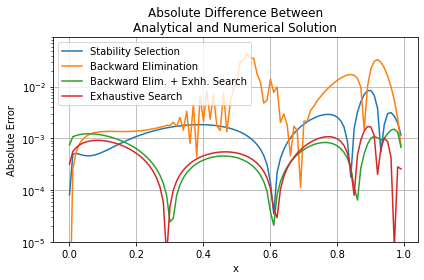

In [148]:
plt.plot(x, np.abs(u_sol[steps]-u_prop_ss[steps]), label="Stability Selection")
plt.plot(x, np.abs(u_sol[steps]-u_prop_be[steps]), label="Backward Elimination")
plt.plot(x, np.abs(u_sol[steps]-u_prop_comb[steps]), label="Backward Elim. + Exhh. Search")
plt.plot(x, np.abs(u_sol[steps]-u_prop_exh[steps]), label="Exhaustive Search")
plt.yscale("log")
plt.ylim(1e-5, 9e-2)
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("Absolute Error")
plt.title("Absolute Difference Between" "\n" "Analytical and Numerical Solution")
plt.tight_layout()
plt.savefig("ESCO/error_trajectories.pdf")